# Visualize and Analyze

This notebook will explore the data we downloaded in the Customize and Access notebook by performing the following steps:

* Load data from our Amazon S3 bucket
* Read in ATL03 and ATL07 data and plot against MODIS Corrected Reflectance (true color) imagery
* 

### Import packages

In [1]:
%run functions.py

In [2]:
from datetime import datetime, timedelta
from collections import defaultdict

from osgeo import gdal, osr
import math
import h5py
import xarray as xr
import pyproj
from shapely.geometry import Point,Polygon

import pyresample as prs
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import hvplot.pandas  # Adds the 'hvplot' method to pandas objects
import hvplot.xarray  # Adds the 'hvplot' method to xarray objects
import plotly.graph_objects as go
from plotly.offline import iplot
import rasterio
import functions

# from pathlib import Path
# import pandas as pd
# import numpy as np
#import geopandas as gpd

%matplotlib inline

Need to install `plotly` on top of Pangeo

In [ ]:
!conda install -c plotly plotly=4.3.0 -y

Installing `awscli` on top of Pangeo 

In [ ]:
!conda install awscli -y

Need to upgrade `pyproj` on this Pangeo environment. Had some issues getting this to install in our environment but this worked:

In [ ]:
import sys
!{sys.executable} -m pip install pyproj

In [ ]:
#!conda list | grep pyproj

## Load data from Amazon s3 bucket

In [26]:
!aws --no-sign-request --region=us-west-2 s3 sync s3://nsidc-agu-tutorial-data/ Outputs

download: s3://nsidc-agu-tutorial-data/snapshot-2019-03-23T00_00_00Z_polar.tiff to Outputs/snapshot-2019-03-23T00_00_00Z_polar.tiff


## Visualize data with MODIS Corrected Reflectance (true color) imagery 

* Overlay ICESat-2 tracks on MODIS Corrected Reflectance as a 3-D plot or using cartopy
    * Overlay photon/height/freeboard on WorldView imagery
    * Example of visualization of data – not really useful for analysis but “pretty” image with qualitative information
    * Higher ATL07 heights along fast ice, lower heights over thin ice and then increasing height.
    * ATL03 should show fewer photon returns over open water and thin ice

### Open ATL03 and ATL07 data

Define variables to extract and combine as a single dataframe:

In [3]:
VARIABLES = {
    'ATL03': [
        '/gt1l/heights/delta_time',
        '/gt1l/heights/h_ph',
        '/gt1l/heights/lat_ph',
        '/gt1l/heights/lon_ph',
        '/gt1l/heights/signal_conf_ph',
        '/gt2l/heights/delta_time',
        '/gt2l/heights/h_ph',
        '/gt2l/heights/lat_ph',
        '/gt2l/heights/lon_ph',
        '/gt2l/heights/signal_conf_ph',
        '/gt3l/heights/delta_time',
        '/gt3l/heights/h_ph',
        '/gt3l/heights/lat_ph',
        '/gt3l/heights/lon_ph',
        '/gt3l/heights/signal_conf_ph'
    ],
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_confidence',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt1l/sea_ice_segments/heights/height_segment_quality',
        '/gt1l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_confidence',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/heights/height_segment_quality',
        '/gt2l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_confidence',
        '/gt3l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/heights/height_segment_quality',
        '/gt3l/sea_ice_segments/heights/height_segment_surface_error_est'
    ]
}

### Load ATL07 granules into a pandas dataframe

We will use the load_icesat2_as_dataframe function from our functions module to load points from our ATL07 files:

In [4]:
# Load both ATL07 granules and combine into a single dataframe

df_07_101341 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323101341_12980201_002_01.h5', VARIABLES)
df_07_211343 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323211343_13050201_002_01.h5', VARIABLES)

frames = [df_07_101341, df_07_211343]
df = pd.concat(frames,ignore_index=True)
df

beam    delta_time  height_segment_confidence  height_segment_height  \
0       gt3l  3.857279e+07                   0.015231               0.040661   
1       gt3l  3.857279e+07                   0.018725              -0.019105   
2       gt3l  3.857279e+07                   0.015820              -0.028619   
3       gt3l  3.857279e+07                   0.014740               0.005093   
4       gt3l  3.857279e+07                   0.017078               0.052944   
...      ...           ...                        ...                    ...   
588501  gt1l  3.861208e+07                   0.020888               0.006713   
588502  gt1l  3.861208e+07                   0.021425               0.006494   
588503  gt1l  3.861208e+07                   0.010047              -0.025439   
588504  gt1l  3.861208e+07                   0.018707              -0.013456   
588505  gt1l  3.861208e+07                   0.014115               0.066488   

        height_segment_quality  height_segment_surface_error_est   latitude  \
0                            1                          0.016271  80.063609   
1                            1                          0.015427  80.063566   
2                            1                          0.017045  80.063520   
3                            1                          0.019076  80.063474   
4                            1                          0.018348  80.063421   
...                        ...                               ...        ...   
588501                       0                          0.012912  80.062659   
588502                       0                          0.013652  80.062865   
588503                       0                          0.012191  80.063062   
588504                       0                          0.017432  80.063258   
588505                       0                          0.024510  80.063462   

         longitude                                           filename  
0       151.988856  processed_ATL07-01_20190323101341_12980201_002...  
1       151.988782  processed_ATL07-01_20190323101341_12980201_002...  
2       151.988704  processed_ATL07-01_20190323101341_12980201_002...  
3       151.988625  processed_ATL07-01_20190323101341_12980201_002...  
4       151.988536  processed_ATL07-01_20190323101341_12980201_002...  
...            ...                                                ...  
588501  143.375424  processed_ATL07-01_20190323211343_13050201_002...  
588502  143.375166  processed_ATL07-01_20190323211343_13050201_002...  
588503  143.374920  processed_ATL07-01_20190323211343_13050201_002...  
588504  143.374675  processed_ATL07-01_20190323211343_13050201_002...  
588505  143.374418  processed_ATL07-01_20190323211343_13050201_002...  

[588506 rows x 9 columns]

### Convert to geopandas dataframe for spatial operations

We will use the convert_to_gdf function from our functions module to convert our DataFrame with 'longitude' and 'latitude' columns to a GeoDataFrame:

In [5]:
gdf = functions.convert_to_gdf(df)
gdf

beam    delta_time  height_segment_confidence  height_segment_height  \
0       gt3l  3.857279e+07                   0.015231               0.040661   
1       gt3l  3.857279e+07                   0.018725              -0.019105   
2       gt3l  3.857279e+07                   0.015820              -0.028619   
3       gt3l  3.857279e+07                   0.014740               0.005093   
4       gt3l  3.857279e+07                   0.017078               0.052944   
...      ...           ...                        ...                    ...   
588501  gt1l  3.861208e+07                   0.020888               0.006713   
588502  gt1l  3.861208e+07                   0.021425               0.006494   
588503  gt1l  3.861208e+07                   0.010047              -0.025439   
588504  gt1l  3.861208e+07                   0.018707              -0.013456   
588505  gt1l  3.861208e+07                   0.014115               0.066488   

        height_segment_quality  height_segment_surface_error_est   latitude  \
0                            1                          0.016271  80.063609   
1                            1                          0.015427  80.063566   
2                            1                          0.017045  80.063520   
3                            1                          0.019076  80.063474   
4                            1                          0.018348  80.063421   
...                        ...                               ...        ...   
588501                       0                          0.012912  80.062659   
588502                       0                          0.013652  80.062865   
588503                       0                          0.012191  80.063062   
588504                       0                          0.017432  80.063258   
588505                       0                          0.024510  80.063462   

         longitude                                           filename  \
0       151.988856  processed_ATL07-01_20190323101341_12980201_002...   
1       151.988782  processed_ATL07-01_20190323101341_12980201_002...   
2       151.988704  processed_ATL07-01_20190323101341_12980201_002...   
3       151.988625  processed_ATL07-01_20190323101341_12980201_002...   
4       151.988536  processed_ATL07-01_20190323101341_12980201_002...   
...            ...                                                ...   
588501  143.375424  processed_ATL07-01_20190323211343_13050201_002...   
588502  143.375166  processed_ATL07-01_20190323211343_13050201_002...   
588503  143.374920  processed_ATL07-01_20190323211343_13050201_002...   
588504  143.374675  processed_ATL07-01_20190323211343_13050201_002...   
588505  143.374418  processed_ATL07-01_20190323211343_13050201_002...   

                          geometry  
0       POINT (151.98886 80.06361)  
1       POINT (151.98878 80.06357)  
2       POINT (151.98870 80.06352)  
3       POINT (151.98863 80.06347)  
4       POINT (151.98854 80.06342)  
...                            ...  
588501  POINT (143.37542 80.06266)  
588502  POINT (143.37517 80.06286)  
588503  POINT (143.37492 80.06306)  
588504  POINT (143.37468 80.06326)  
588505  POINT (143.37442 80.06346)  

[588506 rows x 10 columns]

### Load modis reflectance image

Created GeoTIFF from Worldview: https://go.nasa.gov/2OjfDSa

In [6]:
# read geotiff image from gdal 

gdal.UseExceptions()

fname = './Outputs/snapshot-2019-03-23T00_00_00Z_polar.tiff'

ds = gdal.Open(fname)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print(inproj)

PROJCS["unnamed",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",70],
    PARAMETER["central_meridian",-45],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]


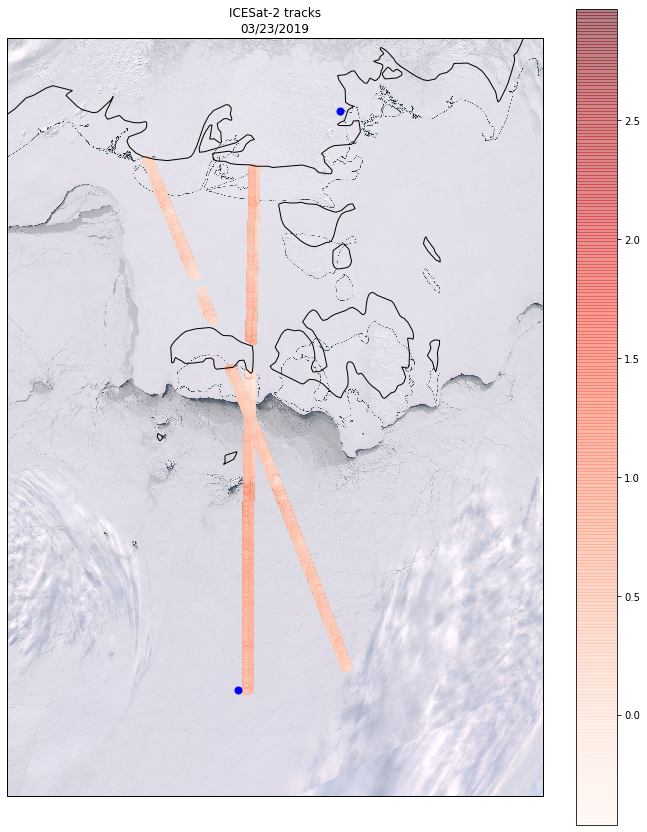

In [29]:
# Read in data using rasterio
fname = './Outputs/snapshot-2019-03-23T00_00_00Z_polar.tiff'
source = rasterio.open(fname, 'r')
bounds = (source.bounds.left, source.bounds.right, \
          source.bounds.bottom, source.bounds.top)

fig = plt.figure(figsize=(12, 15))
img = plt.imread(fname)

ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45.0))
plt.title('ICESat-2 tracks\n'
          '03/23/2019')

# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

# add the image. Because this image was a tif, the "origin" of the image is in the
# upper left corner
ax.imshow(img, origin='upper', extent=bounds, transform=ccrs.NorthPolarStereo(central_longitude=-45.0))
ax.coastlines(resolution='50m', color='black', linewidth=1)

#Subset boundaries
ax.plot(140, 72, 'bo', markersize=7, transform=ccrs.Geodetic())
ax.plot(153, 80, 'bo', markersize=7, transform=ccrs.Geodetic())

#plt.plot(gdf.longitude,gdf.latitude,'o', transform=ccrs.Geodetic())
              
              
#scatter city data, with color reflecting population
# and size reflecting area
heights = ax.scatter(gdf.longitude, gdf.latitude, transform=ccrs.Geodetic(),
          c=gdf.height_segment_height,
          cmap='Reds', alpha=0.5)              

cbar = fig.colorbar(heights, ax=ax)

plt.show()


In [93]:
# # Plotting
# fname = './Outputs/snapshot-2019-03-23T00_00_00Z.tiff'
# source = rasterio.open(fname, 'r')
# red = source.read(1)
# green = source.read(2)
# blue = source.read(3)
# pix = np.dstack((red, green, blue))
# bounds = (source.bounds.left, source.bounds.right, \
#           source.bounds.bottom, source.bounds.top)

# f = plt.figure(figsize=(10,10))
# ax = plt.imshow(pix, extent=bounds)
# plt.plot(gdf.longitude,gdf.latitude,'o')
# plt.show()

### Overlay ATL07 values over MODIS Corrected Reflectance

In [31]:
# Define local filepath

filepath = './Outputs/MOD29_A2019082_0140_006_2019082132036_HEGOUT.hdf'

In [32]:
mod29 = xr.open_dataset(filepath)

In [35]:
mod29

<xarray.Dataset>
Dimensions:                           (Along_swath_lines_1km:MOD_Swath_Sea_Ice: 932, Coarse_swath_lines_5km:MOD_Swath_Sea_Ice: 932, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice: 389, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice: 389)
Dimensions without coordinates: Along_swath_lines_1km:MOD_Swath_Sea_Ice, Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice
Data variables:
    Latitude                          (Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice) float32 ...
    Longitude                         (Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice) float32 ...
    Sea_Ice_by_Reflectance            (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
    Sea_Ice_by_Reflectance_Pixel_QA   (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
 

In [34]:
img = mod29.Ice_Surface_Temperature.hvplot.image().redim.range(Ice_Surface_Temperature=(24000, 27000))
img.options(cmap='PiYG_r')
#img.options(cmap='viridis')

:Image   [Cross_swath_pixels_1km:MOD_Swath_Sea_Ice,Along_swath_lines_1km:MOD_Swath_Sea_Ice]   (Ice_Surface_Temperature)

In [ ]:
# # Paste the OpenAltimetry selection parameters here
# OA_REFERENCE_URL = 'minx=72.0476&miny=36.6165&maxx=72.0505&maxy=36.6214&date=2019-05-02&trackId=516'
# # We populate a list with the photon data using the OpenAltimetry API, no HDF! 
# OA_URL = 'https://openaltimetry.org/data/icesat2/getPhotonData?client=jupyter&' + OA_REFERENCE_URL

# OA_PHOTONS = ['Noise', 'Low', 'Medium', 'High']
# # OA_PLOTTED_BEAMS = [1,2,3,4,5,6] you can select up to 6 beams for each ground track.
# # Some beams may not be usable due cloud covering or QC issues.
# OA_BEAMS = [3,4]

# df_beams = []
# oa_plots = []

# # This function will request the 6 tracks using OpenAltimetry's API
# def getPhotonData():
#     series = []
#     beam_index = 0;
#     for beam in OA_BEAMS:
#         beam_index += 1
#         b_url = OA_URL + '&beam=' + str(beam)
#         print(b_url)
#         print('Requesting Beam {}'.format(beam_index))
#         r = requests.get(b_url)
#         data = r.json()
#         series.append(data)
#     print ('Data requests completed you can now plot it on the next cell...')
#     return series

        
# photon_cloud = getPhotonData()

# track_index = 0
# for track in photon_cloud:
#     track_index +=1
#     for photons in track['series']:
#         if any(word in photons['name'] for word in OA_PHOTONS):
#             series = []
#             for p in photons['data']:
#                 series.append({
#                     'lat': p[0],
#                     'lon': p[2],
#                     'h': p[1]
#                 })
#             if (len(series) > 0):
#                 df = pd.DataFrame.from_dict(series)
#                 df.name = 'Beam ' + str(track_index) + ' ' + photons['name']
#                 df_beams.append(df) 

# for df in df_beams:
#     oa_plots.append(go.Scatter3d(name=df.name, x=df['lat'], y=df['lon'], z=df['h'], mode='markers',
#                                     marker=dict(
#                                         size=1,
#                                         color=df['h'],
#                                         colorscale='Viridis',   # choose a colorscale
#                                         opacity=0.8
#                                     )
#                                 )
#                    )
    
    
# layout = go.Layout(
#     width=900,
#     height=600,
#     scene = dict(aspectmode = 'manual', aspectratio =dict(x=1, y=1, z=0.5),
#                  xaxis=dict(title='Latitude'), yaxis=dict(title='Longitude'), zaxis=dict(title='Elevation (m)'))
# )

# fig = go.Figure(data=oa_plots, layout=layout)  

# iplot(fig)


# # Now we can get a histogram of the beam's elevation and their description
# for df in df_beams:
#     print(df.describe())
#     df.hist('h', bins=128)
    

* Plot IS-2 track on MOD29 IST data
    * Same as for WorldView but using IST
    * May need to composite two or more tiles for coverage
    * May need/want a land mask

In [ ]:
# from mpl_toolkits.basemap import Basemap
# # Lambert Conformal Conic map.
# m = Basemap(llcrnrlon=-100.,llcrnrlat=0.,urcrnrlon=-20.,urcrnrlat=57.,
#             projection='lcc',lat_1=20.,lat_2=40.,lon_0=-60.,
#             resolution ='l',area_thresh=1000.)
# # # read shapefile.
# # shp_info = m.readshapefile('../../../examples/huralll020','hurrtracks',drawbounds=False)
# # # find names of storms that reached Cat 4.
# # names = []
# # for shapedict in m.hurrtracks_info:
# #     cat = shapedict['CATEGORY']
# #     name = shapedict['NAME']
# #     if cat in ['H4','H5'] and name not in names:
# #         # only use named storms.
# #         if name != 'NOT NAMED':  names.append(name)
# # # plot tracks of those storms.
# # for shapedict,shape in zip(m.hurrtracks_info,m.hurrtracks):
# #     name = shapedict['NAME']
# #     cat = shapedict['CATEGORY']
# #     if name in names:
# #         xx,yy = zip(*shape)
# #         # show part of track where storm > Cat 4 as thick red.
# #         if cat in ['H4','H5']:
# #             m.plot(xx,yy,linewidth=1.5,color='r')
# #         elif cat in ['H1','H2','H3']:
# #             m.plot(xx,yy,color='k')

# m.plot()

# # draw coastlines, meridians and parallels.
# m.drawcoastlines()
# m.drawcountries()
# m.drawmapboundary(fill_color='#99ffff')
# m.fillcontinents(color='#cc9966',lake_color='#99ffff')
# m.drawparallels(np.arange(10,70,20),labels=[1,1,0,0])
# m.drawmeridians(np.arange(-100,0,20),labels=[0,0,0,1])
# plt.title('Atlantic Hurricane Tracks (Storms Reaching Category 4, 1851-2004)')
# plt.show()

### Let's start by choosing a single MODIS granule to be used in our analysis below. What is the best MODIS granules to use out of the 13 returned?

I can use Earthdata Search to easily visualize the coverage of each granule:
https://search.earthdata.nasa.gov/search/granules?p=C1000001160-NSIDC_ECS&q=mod29&sb=140%2C72%2C153%2C80&m=80.14349326047419!-42.27686414753069!0!0!0!0%2C2&qt=2019-03-23T00%3A00%3A00.000Z%2C2019-03-23T23%3A59%3A59.999Z&tl=1557787959!4!!

These have full coverage over our study area:

* MOD29.A2019082.0810.006.2019082191746.hdf
* MOD29.A2019082.0630.006.2019082191633.hdf
* MOD29.A2019082.0455.006.2019082132032.hdf
* MOD29.A2019082.0945.006.2019082191513.hdf

And this looks like the best data according to the browse images:

* MOD29.A2019082.0140.006.2019082132036.hdf


### Extract MODIS values that overlap ICESat-2 tracks

* Match up MODIS and ICESat-2 values – depending on IS-2 segment length vs. MODIS footprint, may simply due nearest neighbor, or may want to average (bin) on or the other
* Use MODIS footprint as the baseline and match/bin IS-2 to each MODIS observation


In [ ]:
min_lon, max_lon = mod29.Longitude.min(), mod29.Longitude.max()
min_lat, max_lat = mod29.Latitude.min(), mod29.Latitude.max()
mod29_boundary = Polygon(
    [
        (min_lon, min_lat), 
        (max_lon, min_lat), 
        (max_lon, max_lat), 
        (min_lon, max_lat), 
        (min_lon, min_lat)
    ]
)

### Filtering to MOD29 granule bounding box

In [ ]:
# gdf = gdf[gdf.intersects(mod29_boundary)]
# gdf

### Converting 'delta_time' to datetime values

In [ ]:
EPOCH = datetime(2018, 1, 1, 0, 0, 0)

def convert_delta_time(delta_time):
    '''
    Convert ICESat-2 'delta_time' parameter to UTC datetime
    '''
    utc_datetime = EPOCH + timedelta(seconds=delta_time)

    return utc_datetime

In [ ]:
gdf['utc_datetime'] = gdf['delta_time'].apply(convert_delta_time)
gdf = gdf.drop(columns='delta_time')
gdf

### Compute along track distance

In [ ]:
def compute_along_track_distance(df, ref_point=None):
    '''
    Calculate along track distance for each point, using 'ref_point' as reference.
    Assumes single homogeneous beam profile.

    Arguments:
        df: DataFrame with icesat-2 data
        ref_point: point to use as reference for distance (defaults to first point in dataframe)

    Returuns:
        distance: series of calculated distances along track
    '''
    geod = pyproj.Geod(ellps='WGS84')
    if ref_point is None:
        ref_point = df.iloc[0][['longitude', 'latitude']]

    def calc_distance(row):
        return geod.line_length(*zip(ref_point, row[['longitude', 'latitude']]))

    distance = df.apply(calc_distance, axis=1)

    return distance

In [ ]:
# Warning: rather slow operation here, takes a few minutes for 200000 point
distance = gdf.groupby(['filename', 'beam']).apply(compute_along_track_distance)

### Convert back to pandas dataframe

Have both for good measure (different plotting api's mainly)

In [ ]:
df = pd.DataFrame(gdf.drop(columns='geometry'))
df

### Interpolating MOD29 onto ICESat-2 points

To easily interpolate MOD29 to ICESat-2 points, we can use the `pyresample` library. The `radius_of_influence` parameter determines maximum radius to look for nearest neighbor interpolation.

In [ ]:
icesat2_geometry = prs.geometry.SwathDefinition(lons=df['longitude'], lats=df['latitude'])
mod29_geometry = prs.geometry.SwathDefinition(lons=mod29['Longitude'], lats=mod29['Latitude'])
df['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry, radius_of_influence=1000, fill_value=np.nan)

In [ ]:
mask = df['mod29_ice_surface_temperature'] == 5000
df['mod29_ice_surface_temperature'][mask] = np.nan

### Plot MODIS IST (MOD29) and ICESat-2 height/freeboard along tracks (X-axis = position, Y-axis = IST and height)

* This should show cold IST over the fast ice with fairly flat and higher ICESat-2 heights
* Warm IST will be seen in open water, thin ice just off the fast ice boundary
    * IST will decrease along transect
    * IS-2 should show low heights, but probably low quality (at least for ATL10, if any are available)

### Plot MODIS IST vs. ICESat-2: scatterplot (X-axis = IST, Y-axis = IS-2 height)

* Should show a pretty clear relationship
    * Over fast ice: IST should be close to constant and height will also be fairly constant
    * Over drift ice, where it goes from thin ice toward thicker ice, should see height increasing as IST decreases
    * If we use IST = 271.2 K for open water and then find the IST at the first valid ATL10 value, we have the IST value at that freeboard. Then can use that relationship to get thin ice freeboard where there is ATL07 data, but not ATL10


### Data filtering by quality flag



### Add AMSR2 (AU_SI6) 89V-H difference to MODIS IST and ICESat-2 plots

* Difference for open water/thin ice large (~40-50 K), for thicker ice near zero (<10 K)
* Or calculate the polarization ratio (PR) = (89V – 89H)/(89V + 89H), which is commonly used in the PM sea ice community
* In theory can get concentration from PR (or 89 difference), but don’t really need to do that here.


For each beam group within each file, filter /sea_ice_segments/heights/height_segment_height based on:

/sea_ice_segments/heights/height_segment_quality

### A couple other possibilities:
* Compare cross-over points between tracks 1298 and 1305. 
    * This is over drift ice, but might be able to correlate between them
    * Using all strong beams, there are 9 cross-over points, so there is 
* Compare 1298 repeat track from 12/22/2018 and 3/23/2019
    * For fast ice, should see an increase in height from Dec to Mar as snow depth and ice thickness increases
        * From a quick look at OA, I’m not really seeing this though
        * Not much from ATL10
        * Lots of data in ATL07, but don’t really see a connection – in fact Dec looks lower than Mar; this could be due to corrections/quality issues

In [ ]:
# Using pandas plotting (matplotlib backend)
fig, ax = plt.subplots(figsize=(10, 3))
df.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax)
df.plot(x='utc_datetime', y='height_segment_height', ax=ax, secondary_y=True)

In [ ]:
# Using 'hvplot' (interactive - bokeh backend)
df.hvplot(x='utc_datetime', y='height_segment_height', by='beam', subplots=True).cols(1)

In [ ]:
(df.hvplot(x='utc_datetime', y='height_segment_height') + \
df.hvplot(x='utc_datetime', y='mod29_ice_surface_temperature')).cols(1)